In [126]:
# STEP 1 - 의존성 로드 - O

# STEP 2 - 데이터 임포팅 - O

# STEP 3 - KNN 으로 missing value filling 
# -> O (민경 코드)

# STEP 4 - Data 자체의 구조와 분석 
# -> (histogram-O, pairplot-O, HC-진행중)

# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 
#-> (상관관계-O,다중공선성-일부변수에 대해서만 수행->진행) 

# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 
#-> O // 날리고 살릴 기준이 필요

# STEP 7 - step5, step 6의 결론을 토대로 변수 drop 
#-> 최종 관심 변수 선택 - 

# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정 
#-> 모델별로 달라서 어렵다

# STEP 9 - 피팅한 모델들의 성능 비교 후 
#-> 현재 2형 오류가 너무 많음 

# STEP 10 - 최종 관심 변수가 입력된 단일 샘플의 당뇨병 예측 
#-> 코드 구현 필요 


In [56]:
# STEP 1 -  의존성 로드 ############################################################
import numpy as np
import pandas as pd
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import seaborn as sns # seaborn ref : https://greeksharifa.github.io/machine_learning/2019/12/05/Seaborn-Module/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import statsmodels.api as sm;
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [2]:
# STEP 2 - 데이터 임포팅 ############################################################

df = pd.read_csv("2018_SEL_FILLED.csv") ## 파일리딩!
df.head()

,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DI4_pr,DM1_pr,DM2_pr,DM3_pr,DM4_pr,DJ2_pr,DJ4_pr,DC1_pr,DC2_pr,DC3_pr,DC4_pr,DC5_pr,DC6_pr,DC7_pr,DF2_pr,DL1_pr,DJ0_pr,DJ6_pr,DH4_pr,DH2_pr,DH3_pr,DH6_pr,DN1_pr,DK0_pr,DKNaN_pr,DK4_pr,BHNaN_11,LQ4_00,LQ1_sb,LQ_5EQL,MH1_yr,MO1_wk,educ,EC1_1,BO1,BO1_1,BD1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS1_1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS9_2,BS13,BE3_71,BE3_31,HE_mens,HE_prg,HE_fh,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_HbA1c,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Usg,HE_Unitr,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_pef,HE_cough1,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_FAT,N_SFA,N_MUFA,N_PUFA,N_N3,N_N6,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_VA,N_VA_RAE,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR
0,1,80,2,1,3,7,7129.611906,11065.346820,48804.43027,14516.42326,12602.663140,3,20,2,80.000000,3,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,2,5,2,4,1,2,0,0,19,2,4,2,3,480,480,19,3,2,2,6,0,0,0,0,0,0,162.4,56.0,82.2,21.233226,6.0,2,2,111,43,83,0.55,0.08,12.9,38.7,27,1.48,6.5,1.010,0,0,0,0,0,0,0,2.5700,1.4,68.9,87,35,3.12,6.16,0,0,5,19.2,16.8,5.0,584.617278,843.068846,413.229839,36.421414,18.767787,6.574070,5.710856,4.365616,0.573964,3.800031,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,157.018937,115.820413,494.382289,74.621889,0.664332,0.509876,4.700086,5.846040,53.215661,10
1,1,78,5,5,4,1,7129.611906,3688.448941,19970.18814,14516.42326,4200.887713,2,20,3,1500.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,2,7,1,4,1,2,0,0,15,5,4,3,0,300,420,0,3,2,2,4,0,0,0,0,0,0,167.7,76.4,98.3,27.166096,6.2,4,3,224,36,157,0.51,0.10,14.3,42.6,22,0.95,5.5,1.020,0,0,0,0,0,0,0,0.3960,1.4,100.1,182,38,3.22,8.94,0,0,5,40.5,35.9,5.0,1573.428467,1784.794052,1008.012946,93.260455,25.901406,7.572577,10.233699,3.178905,0.333173,2.843236,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,274.952137,197.537509,928.975532,120.122882,1.175553,1.217959,16.821098,109.102194,83.316037,10
2,2,75,5,5,3,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,3,1500.000000,1,3,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,2,2,1,2,1,5,2,4,1,1,0,2,0,0,3,3,0,360,480,0,3,1,2,2,0,0,1,0,0,1,157.7,53.2,80.7,21.391845,5.2,2,3,165,44,101,0.59,12.06,14.3,42.3,15,0.57,6.0,1.024,0,0,0,0,0,0,0,0.7875,1.4,105.1,153,66,1.72,4.56,1,0,5,15.3,10.3,5.0,1194.733365,1984.263560,758.479721,42.516444,60.305901,23.130683,21.015233,12.467458,2.193219,10.279590,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,948.965037,601.616567,4168.181635,254.268098,0.638100,1.337223,4.785608,96.546711,78.771586,10
3,2,80,2,1,1,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,1,75.666667,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,1,3,2,3,1,1,0,1,0,0,4,3,0,450,450,0,2,2,2,4,0,0,0,0,0,0,146.1,57.6,93.0,26.984977,7.3,4,3,160,32,229,0.52,0.06,10.3,30.2,23,0.98,5.0,1.013,0,0,0,0,0,0,0,0.4480,1.4,67.3,140,35,2.24,3.06,0,0,2,8.6,14.6,2.5,526.064249,1019.718446,271.549260,24.806971,7.543745,2.329953,1.939842,2.932005,0.356655,2.572942,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,96.834167,48.430128,580.848469,0.026089,0.877007,0.305087,6.082442,10.749817,51.281633,10
4,2,71,2,1,4,7,7129.611906,3315.581424,19970.18814,14516.42326,3268.787290,2,20,1,75.666667,4,3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,2,1,7,2,2,1,2,0,1,21,1,4,3,0,300,360,0,3,2,2,0,0,0,1,0,0,1,157.2,53.2,78.4,21.528142,7.4,2,3,167,62,54,0.64,0.04,12.6,37.5,25,0.71,6.0,1.022,0,0,4,0,0,0,0,0.8110,1.4,62.7,159,38,2.43,5.89,0,0

In [3]:
# STEP 3 - KNN 으로 missing value filling ############################################################
#df=df.fillna(method='pad')

# df = pd.read_excel('test.xlsx')
# imputer = KNNImputer(n_neighbors=11)
# data_filled = imputer.fit_transform(df)
# data_filled = data_filled.astype('int64')
# download = pd.DataFrame(data_filled).to_csv('filled.csv')

# df = pd.read_excel('test.xlsx')
# data_filled = df.where(pd.notnull(df), df.median(), axis='columns')
# download = pd.DataFrame(data_filled).to_csv('filled.csv')

#df=df.drop(df.columns[0], axis='columns') #unnamed drop 없을경우 주석 처리
df.isnull()

,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DI4_pr,DM1_pr,DM2_pr,DM3_pr,DM4_pr,DJ2_pr,DJ4_pr,DC1_pr,DC2_pr,DC3_pr,DC4_pr,DC5_pr,DC6_pr,DC7_pr,DF2_pr,DL1_pr,DJ0_pr,DJ6_pr,DH4_pr,DH2_pr,DH3_pr,DH6_pr,DN1_pr,DK0_pr,DKNaN_pr,DK4_pr,BHNaN_11,LQ4_00,LQ1_sb,LQ_5EQL,MH1_yr,MO1_wk,educ,EC1_1,BO1,BO1_1,BD1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS1_1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS9_2,BS13,BE3_71,BE3_31,HE_mens,HE_prg,HE_fh,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_HbA1c,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Usg,HE_Unitr,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_pef,HE_cough1,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_FAT,N_SFA,N_MUFA,N_PUFA,N_N3,N_N6,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_VA,N_VA_RAE,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

0       2
1       3
2       3
3       3
4       3
       ..
4721    1
4722    1
4723    1
4724    2
4725    1
Name: HE_DM, Length: 4726, dtype: int64

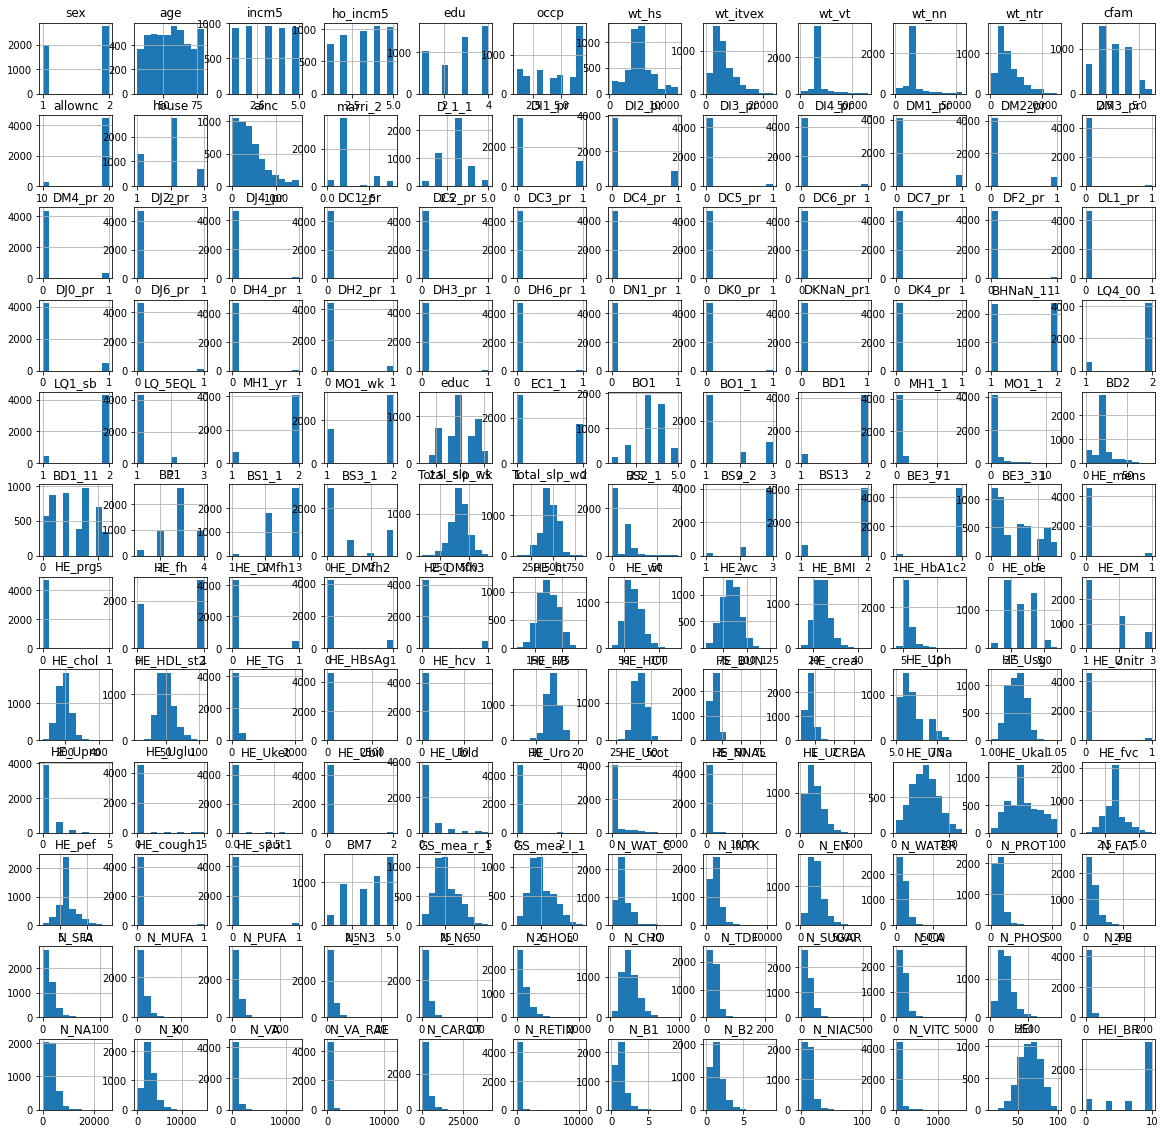

In [4]:
# STEP 4 - Data에 대한 구조와 분석
df.hist(figsize=(20,20))#histogram plotting
#sns.paiplot(df)
df.head()
df['HE_DM']

In [5]:
# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 #################################################################### 

## 변수간 상관관계 분석 - 1 
t=df.corr(method='pearson') ## de1_pr 현재 당뇨병 유병 여부와 상관관계가 있는 변수들
t.HE_DM

sex            -0.136081
age             0.280209
incm5          -0.067033
ho_incm5       -0.027450
edu            -0.214252
occp            0.123202
wt_hs           0.002368
wt_itvex       -0.057395
wt_vt          -0.011756
wt_nn          -0.029650
wt_ntr         -0.038942
cfam           -0.146654
allownc        -0.077856
house           0.016118
ainc           -0.160227
marri_2         0.077422
D_1_1           0.138468
DI1_pr          0.297300
DI2_pr          0.238316
DI3_pr          0.069801
DI4_pr          0.078165
DM1_pr          0.066197
DM2_pr          0.074549
DM3_pr         -0.011978
DM4_pr          0.028438
DJ2_pr         -0.007449
DJ4_pr          0.013580
DC1_pr          0.034264
DC2_pr         -0.007449
DC3_pr         -0.006160
DC4_pr         -0.013244
DC5_pr          0.009145
DC6_pr          0.005937
DC7_pr         -0.031831
DF2_pr          0.024265
DL1_pr         -0.021910
DJ0_pr         -0.093593
DJ6_pr          0.010324
DH4_pr          0.011215
DH2_pr          0.048866


,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DI4_pr,DM1_pr,DM2_pr,DM3_pr,DM4_pr,DJ2_pr,DJ4_pr,DC1_pr,DC2_pr,DC3_pr,DC4_pr,DC5_pr,DC6_pr,DC7_pr,DF2_pr,DL1_pr,DJ0_pr,DJ6_pr,DH4_pr,DH2_pr,DH3_pr,DH6_pr,DN1_pr,DK0_pr,DKNaN_pr,DK4_pr,BHNaN_11,LQ4_00,LQ1_sb,LQ_5EQL,MH1_yr,MO1_wk,educ,EC1_1,BO1,BO1_1,BD1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS1_1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS9_2,BS13,BE3_71,BE3_31,HE_mens,HE_prg,HE_fh,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_HbA1c,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Usg,HE_Unitr,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_pef,HE_cough1,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_FAT,N_SFA,N_MUFA,N_PUFA,N_N3,N_N6,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_VA,N_VA_RAE,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR
sex,1.000000,0.001306,-0.001773,-0.007304,-0.133459,0.153090,-0.004742,-0.183309,-0.053663,-0.013237,-0.220838,-0.014197,-0.050019,-0.034585,-0.035504,0.191506,0.060308,-0.015615,0.046551,-0.023122,-0.083153,0.190007,0.180754,0.064084,0.214599,0.004279,0.033576,-0.024962,-0.029797,-0.012578,0.055141,0.012305,-0.030101,0.040006,0.075680,-0.008759,0.041875,-0.026578,-0.009803,0.066586,-0.018095,0.004893,0.003512,-0.024115,0.009861,-0.051454,-0.062795,-0.002298,-0.049879,0.083763,-0.016679,-0.058033,-0.167860,0.228783,0.086018,0.063628,-0.198255,0.029575,0.070430,0.130345,-0.358910,-0.038363,0.663632,-0.620677,0.004685,-0.005989,-0.600999,-0.147498,0.079430,0.099007,0.032813,0.165862,0.044423,0.085091,0.001872,0.019019,0.033771,-0.700505,-0.535851,-0.381396,-0.131033,-0.072807,-0.146789,-0.136081,0.047575,0.282529,-0.200575,-0.029307,-0.003935,-0.628153,-0.607209,-0.121537,-0.598699,0.034296,-0.183394,0.126303,-0.112811,-0.110231,0.017873,-0.050520,0.151217,-0.023514,-0.337202,-0.159345,-0.284393,-0.106371,-0.059813,-0.549477,-0.491111,0.002783,-0.053165,0.037367,-0.703007,-0.725424,-0.145309,-0.269370,-0.394355,-0.150344,-0.329544,-0.214600,-0.197978,-0.200688,-0.182474,-0.116296,-0.181695,-0.174934,-0.313509,-0.172313,-0.098883,-0.194668,-0.320433,-0.248955,-0.311197,-0.235061,-0.097118,-0.087221,-0.090879,-0.051084,-0.304241,-0.238044,-0.298199,-0.070105,0.104246,0.000305
age,0.001306,1.000000,0.004196,-0.137930,-0.643799,0.439255,-0.016072,-0.325333,-0.027306,-0.150316,-0.316233,-0.398968,-0.082495,0.037236,-0.356861,0.356305,0.209550,0.476539,0.282068,0.151725,0.180401,0.329916,0.320002,0.094450,0.284297,0.028140,0.074186,0.042908,0.022211,0.040191,0.023484,0.003239,0.028066,0.005398,0.071712,-0.052008,-0.165808,-0.029944,0.016070,0.267050,0.134827,0.074497,0.039317,0.025037,0.023938,0.044685,-0.418655,-0.181642,-0.020420,0.108781,-0.026848,-0.145871,-0.611193,0.342911,-0.163784,-0.218574,-0.281342,0.032613,0.166818,0.133729,-0.278041,0.205916,0.050934,0.032254,0.039301,-0.147936,0.021745,0.058197,0.117543,0.050251,-0.086111,-0.202274,-0.080681,-0.177419,-0.191994,-0.097325,0.146338,-0.382458,-0.221816,0.179697,0.032488,0.284613,0.041283,0.280209,-0.141991,-0.145373,-0.008104,-0.037164,0.055336,-0.124754,-0.137940,0.373678,0.135559,0.097493,-0.189349,0.112755,0.047914,0.058996,-0.053872,-0.004015,0.021533,0.009222,-0.162604,-0.070949,-0.308658,0.066431,0.043447,-0.276252,-0.250224,0.115548,0.112253,-0.312109,-0.326686,-0.322474,-0.109443,-0.246580,-0.222230,-0.192980,-0.263853,-0.348618,-0.349700,-0.331114,-0.258441,-0.084647,-0.276178,-0.307597,-0.038059,0.042119,-0.167357,-0.109584,-0.195875,-0.066687,-0.185712,-0.102694,-0.087584,-0.108036,-0.025164,-0.119719,-0.143266,-0.282662,-0.263990,-0.075184,0.192883,0.405059
incm5,-0.001773,0.004196,1.000000,0.185287,0.186362,-0.187438,-0.048629,-0.052991,0.037463,0.030285,-0.032311,0.152597,0.163706,0.298936,0.741919,-0.128842,-0.130281,-0.045118,0.014779,-0.035040,-0.001987,-0.036851,-0.032985,-0.015

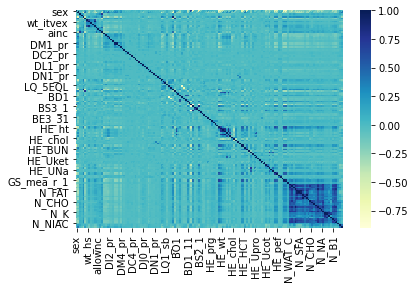

In [6]:
#변수간 상관관계 분석 - 2
sns.heatmap(df.corr(),cmap="YlGnBu")
t.head(200)

In [8]:
## VIF 산출
df.dropna(inplace=True)
df['intercept'] = 1
lm = sm.OLS(df['HE_DM'], df)
results = lm.fit()
results.summary()

# dmatrix 사용을 위한 모든 변수에 대한 string +
cols = ''
for col in list(df):
    if(col=='sex'):
        cols = cols + str(col)
    else:
        cols = cols + ' + ' + str(col)
print(cols)

sex + age + incm5 + ho_incm5 + edu + occp + wt_hs + wt_itvex + wt_vt + wt_nn + wt_ntr + cfam + allownc + house + ainc + marri_2 + D_1_1 + DI1_pr + DI2_pr + DI3_pr + DI4_pr + DM1_pr + DM2_pr + DM3_pr + DM4_pr + DJ2_pr + DJ4_pr + DC1_pr + DC2_pr + DC3_pr + DC4_pr + DC5_pr + DC6_pr + DC7_pr + DF2_pr + DL1_pr + DJ0_pr + DJ6_pr + DH4_pr + DH2_pr + DH3_pr + DH6_pr + DN1_pr + DK0_pr + DKNaN_pr + DK4_pr + BHNaN_11 + LQ4_00 + LQ1_sb + LQ_5EQL + MH1_yr + MO1_wk + educ + EC1_1 + BO1 + BO1_1 + BD1 + MH1_1 + MO1_1 + BD2 + BD1_11 + BP1 + BS1_1 + BS3_1 + Total_slp_wk + Total_slp_wd + BS2_1 + BS9_2 + BS13 + BE3_71 + BE3_31 + HE_mens + HE_prg + HE_fh + HE_DMfh1 + HE_DMfh2 + HE_DMfh3 + HE_ht + HE_wt + HE_wc + HE_BMI + HE_HbA1c + HE_obe + HE_DM + HE_chol + HE_HDL_st2 + HE_TG + HE_HBsAg + HE_hcv + HE_HB + HE_HCT + HE_BUN + HE_crea + HE_Uph + HE_Usg + HE_Unitr + HE_Upro + HE_Uglu + HE_Uket + HE_Ubil + HE_Ubld + HE_Uro + HE_Ucot + HE_NNAL + HE_UCREA + HE_UNa + HE_Ukal + HE_fvc + HE_pef + HE_cough1 + HE_sput

In [9]:
## VIF 지수 산출 - 10 이상인 친구들     
y, X = dmatrices('HE_DM ~'+ cols , df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
# ov_list=list(vif,list(vif['VIF Factor']>10))
# print(ov_list)
vif.head(200)
over_vif_vars = vif[vif['VIF Factor']>10]
over_vif_vars.head(200)

c:\users\좌\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\users\좌\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
22,4.044691e+01,DM1_pr
23,3.586832e+01,DM2_pr
78,2.404260e+01,HE_ht
79,6.218491e+01,HE_wt
81,4.207561e+01,HE_BMI
90,1.740906e+01,HE_HB
91,1.680023e+01,HE_HCT
116,1.684705e+01,N_INTK
117,2.518310e+01,N_EN
119,1.430553e+01,N_PROT


In [10]:

# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 #########################################################################

#인코딩
df.loc[df["HE_DM"] == 1,"HE_DM"] = 0
df.loc[df["HE_DM"] == 2,"HE_DM"] = 0
df.loc[df["HE_DM"] == 3,"HE_DM"] = 1
df['HE_DM'].head(100)


importance_list = []
y = df.HE_DM # y축 설정
x = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(x_train,y_train)
for name, score in zip(df[:],rnd_clf.feature_importances_): ## RF 적 방법으로 변수 중요도 추출
    importance_list = importance_list + [name,score]
    print(name, round(score,6))

sex 0.000998
age 0.013871
incm5 0.00256
ho_incm5 0.002722
edu 0.005267
occp 0.002895
wt_hs 0.006454
wt_itvex 0.007084
wt_vt 0.003527
wt_nn 0.004154
wt_ntr 0.006812
cfam 0.003625
allownc 0.001053
house 0.001972
ainc 0.010894
marri_2 0.001765
D_1_1 0.003173
DI1_pr 0.011699
DI2_pr 0.009631
DI3_pr 0.001074
DI4_pr 0.00064
DM1_pr 0.000892
DM2_pr 0.000852
DM3_pr 0.000308
DM4_pr 0.000661
DJ2_pr 1.3e-05
DJ4_pr 0.000392
DC1_pr 0.000726
DC2_pr 0.0
DC3_pr 0.00026
DC4_pr 0.000351
DC5_pr 0.0
DC6_pr 8.8e-05
DC7_pr 0.000173
DF2_pr 0.000387
DL1_pr 0.000129
DJ0_pr 0.000364
DJ6_pr 0.000417
DH4_pr 0.000375
DH2_pr 0.001291
DH3_pr 0.000578
DH6_pr 0.000579
DN1_pr 0.000312
DK0_pr 0.000274
DKNaN_pr 0.000426
DK4_pr 0.000571
BHNaN_11 0.001016
LQ4_00 0.000689
LQ1_sb 0.000523
LQ_5EQL 0.001209
MH1_yr 0.000658
MO1_wk 0.000843
educ 0.005524
EC1_1 0.001069
BO1 0.003077
BO1_1 0.001646
BD1 0.000935
MH1_1 0.001166
MO1_1 0.002061
BD2 0.006016
BD1_11 0.003361
BP1 0.001789
BS1_1 0.000766
BS3_1 0.001765
Total_slp_wk 0.006661

In [11]:
# STEP 7 - step5, step 6의 결론을 토대로 변수 drop ######################################################################
df = df.drop(['HE_HbA1c','HE_Uglu'],axis='columns')

In [12]:
#############STEP 7 - VIF 날림############
df=df.drop(['N_FAT','N_MUFA','N_N6','N_VA_RAE','N_CAROT','N_RETIN','N_PUFA','N_VA'],axis='columns')

In [13]:
#############STEP 7 - RF 중요도 날림#########3
df = df.drop(['DI4_pr','DM1_pr','DM2_pr','DM3_pr','DM4_pr','DJ2_pr','DJ4_pr','DC1_pr','DC2_pr','DC3_pr','DC3_pr','DC4_pr','DC5_pr','DC6_pr','DC7_pr','DF2_pr', 'DL1_pr', 'DJ0_pr', 'DJ6_pr', 'DH4_pr', 'DH3_pr', 'DH6_pr', 'DN1_pr', 'DK0_pr', 'DKNaN_pr', 'DK4_pr', 'LQ4_00', 'LQ1_sb', 'MH1_yr', 'MO1_wk','BD1','BS1_1','BS9_2','BE3_71','HE_mens','HE_prg','HE_DMfh1','HE_Usg','HE_Uket','HE_Ubld','HE_pef','HE_cough1'],axis='columns')
df.head()
############# STEP 7 - 52개 날라감  143 - 52 = 91 #####################

,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DH2_pr,BHNaN_11,LQ_5EQL,educ,EC1_1,BO1,BO1_1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS13,BE3_31,HE_fh,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Unitr,HE_Upro,HE_Ubil,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR,intercept
0,1,80,2,1,3,7,7129.611906,11065.346820,48804.43027,14516.42326,12602.663140,3,20,2,80.000000,3,3,1,1,0,0,1,1,5,2,4,1,0,0,19,2,4,3,480,480,19,2,6,0,0,0,162.4,56.0,82.2,21.233226,2,0,111,43,83,0.55,0.08,12.9,38.7,27,1.48,6.5,0,0,0,0,2.5700,1.4,68.9,87,35,3.12,0,5,19.2,16.8,5.0,584.617278,843.068846,413.229839,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,0.664332,0.509876,4.700086,5.846040,53.215661,10,1
1,1,78,5,5,4,1,7129.611906,3688.448941,19970.18814,14516.42326,4200.887713,2,20,3,1500.000000,1,1,0,0,0,0,1,1,7,1,4,1,0,0,15,5,4,0,300,420,0,2,4,0,0,0,167.7,76.4,98.3,27.166096,4,1,224,36,157,0.51,0.10,14.3,42.6,22,0.95,5.5,0,0,0,0,0.3960,1.4,100.1,182,38,3.22,0,5,40.5,35.9,5.0,1573.428467,1784.794052,1008.012946,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,1.175553,1.217959,16.821098,109.102194,83.316037,10,1
2,2,75,5,5,3,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,3,1500.000000,1,3,1,0,0,1,1,1,5,2,4,1,0,2,0,0,3,0,360,480,0,1,2,1,0,1,157.7,53.2,80.7,21.391845,2,1,165,44,101,0.59,12.06,14.3,42.3,15,0.57,6.0,0,0,0,0,0.7875,1.4,105.1,153,66,1.72,0,5,15.3,10.3,5.0,1194.733365,1984.263560,758.479721,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,0.638100,1.337223,4.785608,96.546711,78.771586,10,1
3,2,80,2,1,1,7,7129.611906,5244.077972,19970.18814,14516.42326,5622.287006,2,20,1,75.666667,3,1,0,0,0,0,1,1,3,2,3,1,0,1,0,0,4,0,450,450,0,2,4,0,0,0,146.1,57.6,93.0,26.984977,4,1,160,32,229,0.52,0.06,10.3,30.2,23,0.98,5.0,0,0,0,0,0.4480,1.4,67.3,140,35,2.24,0,2,8.6,14.6,2.5,526.064249,1019.718446,271.549260,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,0.877007,0.305087,6.082442,10.749817,51.281633,10,1
4,2,71,2,1,4,7,7129.611906,3315.581424,19970.18814,14516.42326,3268.787290,2,20,1,75.666667,4,3,1,0,0,0,1,1,7,2,2,1,0,1,21,1,4,0,300,360,0,2,0,1,0,1,157.2,53.2,78.4,21.528142,2,1,167,62,54,0.64,0.04,12.6,37.5,25,0.71,6.0,0,0,0,0,0.8110,1.4,62.7,159,38,2.43,0,2,15.3,14.3,10.0,1271.085794,1286.795194,540.182372,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,587.222358,793.749899,4.773000,605.814716,2280.084010,0.646209,1.248963,6.526215,36.724796,76.575833,10,1


0.8603667136812412


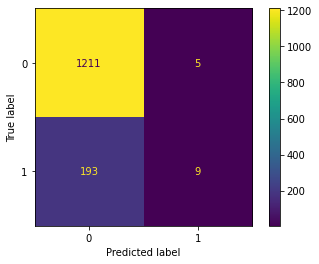

In [14]:
# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정  ########################################################################

## 데이터 분류 및 전처리
# 축 분리#te
Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions

# 사이킷런 셋 분류 함수 : http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) ## test.size 0.2~0.25 설정할거임


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
plot_confusion_matrix(pipe,X_test,Y_test)

0       0
1       1
2       1
3       1
4       1
       ..
4721    0
4722    0
4723    0
4724    0
4725    0
Name: HE_DM, Length: 4726, dtype: int64

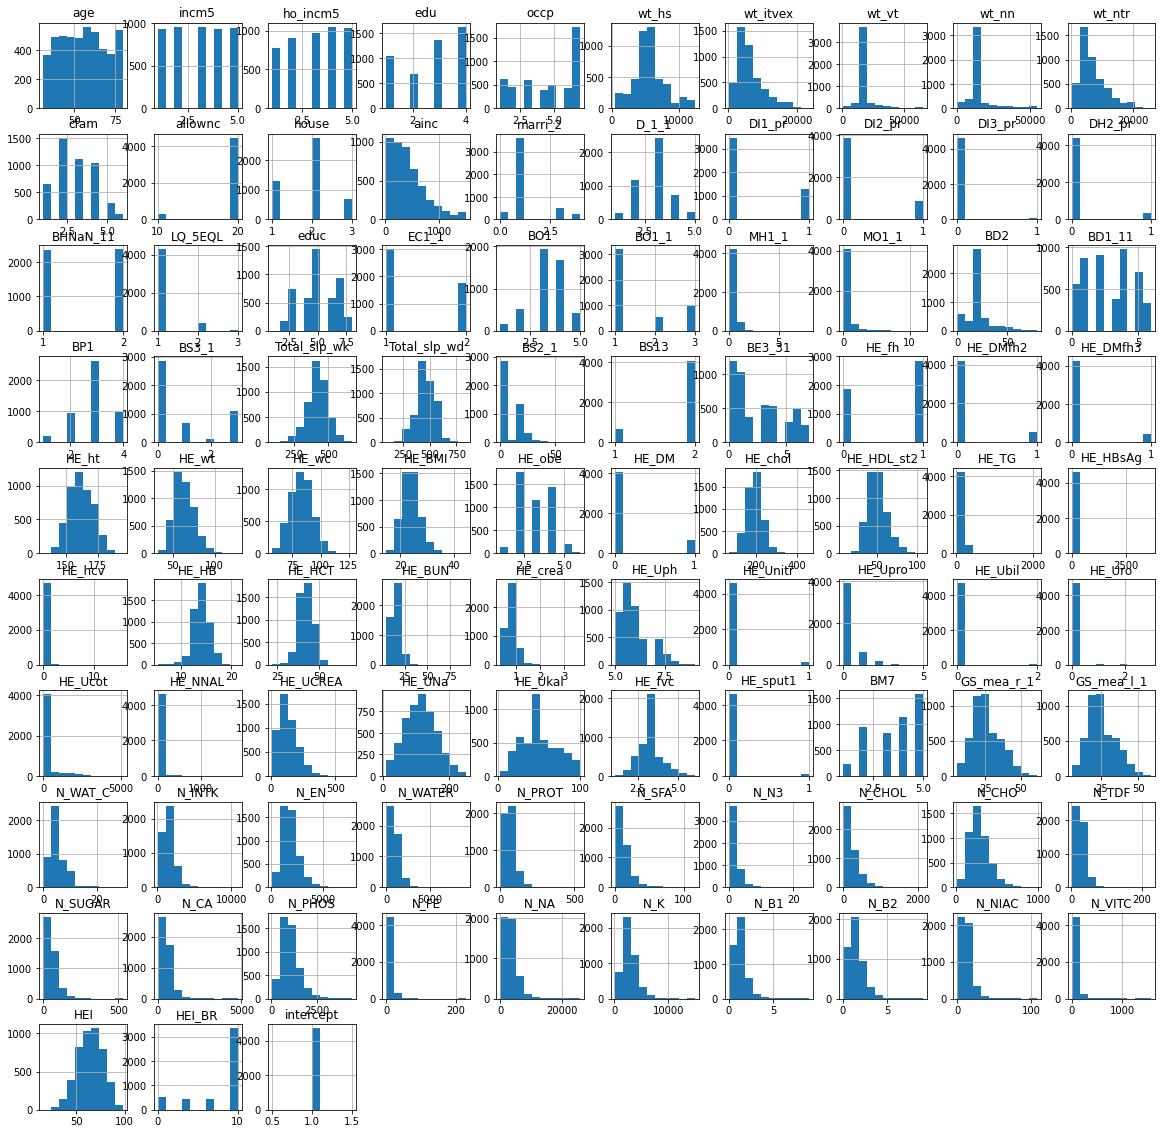

In [36]:
##########################PHASE2######################
# STEP 4 - Data에 대한 구조와 분석
df.hist(figsize=(20,20))#histogram plotting
#sns.paiplot(df)
df.head()
df['HE_DM']

In [15]:
# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 #################################################################### 

## 변수간 상관관계 분석 - 1 
t=df.corr(method='pearson') ## de1_pr 현재 당뇨병 유병 여부와 상관관계가 있는 변수들
t.HE_DM

sex            -0.076824
age             0.239156
incm5          -0.063974
ho_incm5       -0.030127
edu            -0.191204
occp            0.117487
wt_hs          -0.010544
wt_itvex       -0.077555
wt_vt          -0.022300
wt_nn          -0.035757
wt_ntr         -0.072860
cfam           -0.144739
allownc        -0.069189
house          -0.000232
ainc           -0.144718
marri_2         0.066143
D_1_1           0.149395
DI1_pr          0.260335
DI2_pr          0.230516
DI3_pr          0.085945
DH2_pr          0.064259
BHNaN_11       -0.104962
LQ_5EQL         0.035422
educ           -0.184638
EC1_1           0.085002
BO1             0.059861
BO1_1          -0.035070
MH1_1           0.008701
MO1_1           0.035538
BD2             0.000586
BD1_11         -0.049406
BP1             0.036391
BS3_1           0.063373
Total_slp_wk    0.009047
Total_slp_wd   -0.043168
BS2_1           0.058243
BS13           -0.005335
BE3_31          0.008557
HE_fh          -0.001832
HE_DMfh2        0.067290


,sex,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,allownc,house,ainc,marri_2,D_1_1,DI1_pr,DI2_pr,DI3_pr,DH2_pr,BHNaN_11,LQ_5EQL,educ,EC1_1,BO1,BO1_1,MH1_1,MO1_1,BD2,BD1_11,BP1,BS3_1,Total_slp_wk,Total_slp_wd,BS2_1,BS13,BE3_31,HE_fh,HE_DMfh2,HE_DMfh3,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HB,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Unitr,HE_Upro,HE_Ubil,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_fvc,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_EN,N_WATER,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_B1,N_B2,N_NIAC,N_VITC,HEI,HEI_BR,intercept
sex,1.000000,0.001306,-0.001773,-0.007304,-0.133459,0.153090,-0.004742,-0.183309,-0.053663,-0.013237,-0.220838,-0.014197,-0.050019,-0.034585,-0.035504,0.191506,0.060308,-0.015615,0.046551,-0.023122,0.066586,-0.062795,0.083763,-0.167860,0.228783,0.086018,0.063628,0.029575,0.070430,0.130345,-0.358910,-0.038363,-0.620677,0.004685,-0.005989,-0.600999,0.079430,0.032813,0.085091,0.019019,0.033771,-0.700505,-0.535851,-0.381396,-0.131033,-0.146789,-0.076824,0.047575,0.282529,-0.200575,-0.029307,-0.003935,-0.628153,-0.607209,-0.121537,-0.598699,0.034296,0.126303,-0.112811,-0.050520,-0.023514,-0.337202,-0.159345,-0.284393,-0.106371,-0.059813,-0.549477,-0.053165,0.037367,-0.703007,-0.725424,-0.145309,-0.269370,-0.394355,-0.150344,-0.329544,-0.197978,-0.116296,-0.174934,-0.313509,-0.172313,-0.098883,-0.194668,-0.320433,-0.248955,-0.311197,-0.235061,-0.304241,-0.238044,-0.298199,-0.070105,0.104246,0.000305,NaN
age,0.001306,1.000000,0.004196,-0.137930,-0.643799,0.439255,-0.016072,-0.325333,-0.027306,-0.150316,-0.316233,-0.398968,-0.082495,0.037236,-0.356861,0.356305,0.209550,0.476539,0.282068,0.151725,0.267050,-0.418655,0.108781,-0.611193,0.342911,-0.163784,-0.218574,0.032613,0.166818,0.133729,-0.278041,0.205916,0.032254,0.039301,-0.147936,0.021745,0.117543,-0.086111,-0.177419,-0.097325,0.146338,-0.382458,-0.221816,0.179697,0.032488,0.041283,0.239156,-0.141991,-0.145373,-0.008104,-0.037164,0.055336,-0.124754,-0.137940,0.373678,0.135559,0.097493,0.112755,0.047914,-0.004015,0.009222,-0.162604,-0.070949,-0.308658,0.066431,0.043447,-0.276252,0.112253,-0.312109,-0.326686,-0.322474,-0.109443,-0.246580,-0.222230,-0.192980,-0.263853,-0.349700,-0.084647,-0.307597,-0.038059,0.042119,-0.167357,-0.109584,-0.195875,-0.066687,-0.185712,-0.102694,-0.143266,-0.282662,-0.263990,-0.075184,0.192883,0.405059,NaN
incm5,-0.001773,0.004196,1.000000,0.185287,0.186362,-0.187438,-0.048629,-0.052991,0.037463,0.030285,-0.032311,0.152597,0.163706,0.298936,0.741919,-0.128842,-0.130281,-0.045118,0.014779,-0.035040,0.017909,0.019489,-0.082925,0.210244,-0.090416,-0.015263,-0.040126,-0.024837,0.005481,-0.014920,0.021101,0.055391,-0.022416,-0.043909,0.000947,-0.065797,0.032899,0.036303,0.008573,-0.021612,-0.025105,0.046150,-0.018434,-0.051583,-0.067200,-0.051636,-0.063974,-0.005867,0.034194,-0.037265,-0.000370,-0.022732,0.033846,0.036926,0.029518,0.029576,0.025007,0.009537,-0.040248,-0.029381,-0.010570,-0.080145,-0.076843,-0.009753,-0.007444,-0.021951,0.043639,-0.013231,0.107308,0.035004,0.034606,-0.005243,0.141159,0.067656,0.161786,0.099593,0.060230,0.068520,0.100511,0.045822,0.109432,0.124825,0.071795,0.110196,0.070748,0.051149,0.125419,0.043752,0.097860,0.093252,0.073845,0.139750,0.034082,NaN
ho_incm5,-0.007304,-0.137930,0.185287,1.000000,0.177689,-0.104047,-0.011519,0.040008,0.035013,0.068265,0.049874,0.144045,0.067881,0.065488,0.251242,-0.082916,-0.074042,-0.075351,-0.024795,-0.007411,-0.032219,0.053123,0.014708,0.190992,-0.046485,0.015993,-0.004092,-0.024501,-0.014145,-0.046116,0.043598,-0.046414,0.011230,-0.031988,0.002725,-0.000116,-0.013810,0.019949,0.034393,0.012009,-0.019906,0.079412,0.028203,-0.026740,-0.030626,-0.025232,-0.030127,0.048078,0.049316,-0.011820,-0.022220,-0.008017,0.041009,0.051227,-0.041824,0.011884,-0.010330,-0.030133,-0.020692,0.006602,0.005938,0.004279,-0.037741,0.033068,-0.013127,-0.007989,0.050803,-0.013869,0.06

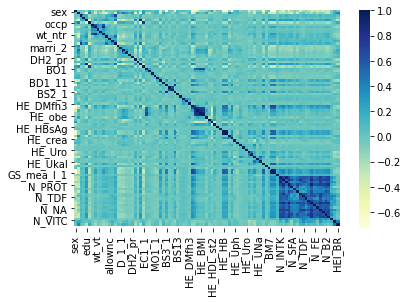

In [16]:
#변수간 상관관계 분석 - 2
sns.heatmap(df.corr(),cmap="YlGnBu")
t.head(200)

In [17]:
## VIF 산출
df['intercept'] = 1
lm = sm.OLS(df['HE_DM'], df)
results = lm.fit()
results.summary()

# dmatrix 사용을 위한 모든 변수에 대한 string +
cols = ''
for col in list(df):
    if(col=='sex'):
        cols = cols + str(col)
    else:
        cols = cols + ' + ' + str(col)
print(cols)

sex + age + incm5 + ho_incm5 + edu + occp + wt_hs + wt_itvex + wt_vt + wt_nn + wt_ntr + cfam + allownc + house + ainc + marri_2 + D_1_1 + DI1_pr + DI2_pr + DI3_pr + DH2_pr + BHNaN_11 + LQ_5EQL + educ + EC1_1 + BO1 + BO1_1 + MH1_1 + MO1_1 + BD2 + BD1_11 + BP1 + BS3_1 + Total_slp_wk + Total_slp_wd + BS2_1 + BS13 + BE3_31 + HE_fh + HE_DMfh2 + HE_DMfh3 + HE_ht + HE_wt + HE_wc + HE_BMI + HE_obe + HE_DM + HE_chol + HE_HDL_st2 + HE_TG + HE_HBsAg + HE_hcv + HE_HB + HE_HCT + HE_BUN + HE_crea + HE_Uph + HE_Unitr + HE_Upro + HE_Ubil + HE_Uro + HE_Ucot + HE_NNAL + HE_UCREA + HE_UNa + HE_Ukal + HE_fvc + HE_sput1 + BM7 + GS_mea_r_1 + GS_mea_l_1 + N_WAT_C + N_INTK + N_EN + N_WATER + N_PROT + N_SFA + N_N3 + N_CHOL + N_CHO + N_TDF + N_SUGAR + N_CA + N_PHOS + N_FE + N_NA + N_K + N_B1 + N_B2 + N_NIAC + N_VITC + HEI + HEI_BR + intercept


In [18]:
## VIF 지수 산출 - 10 이상인 친구들     
y, X = dmatrices('HE_DM ~'+ cols , df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
# ov_list=list(vif,list(vif['VIF Factor']>10))
# print(ov_list)
vif.head(200)
over_vif_vars = vif[vif['VIF Factor']>10]
over_vif_vars.head(200)

c:\users\좌\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
42,23.607829,HE_ht
43,60.825181,HE_wt
45,41.075325,HE_BMI
53,16.887800,HE_HB
54,16.288114,HE_HCT
73,16.073947,N_INTK
74,22.181773,N_EN
76,13.211910,N_PROT
84,18.532534,N_PHOS


In [19]:
# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 #########################################################################

importance_list = []
y = df.HE_DM # y축 설정
x = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(x_train,y_train)
for name, score in zip(df[:],rnd_clf.feature_importances_): ## RF 적 방법으로 변수 중요도 추출
    importance_list = importance_list + [name,score]
    print(name, round(score,6))

sex 0.001716
age 0.024309
incm5 0.004876
ho_incm5 0.005133
edu 0.007141
occp 0.005254
wt_hs 0.012569
wt_itvex 0.013243
wt_vt 0.006028
wt_nn 0.008625
wt_ntr 0.013222
cfam 0.006438
allownc 0.001546
house 0.003436
ainc 0.018646
marri_2 0.002938
D_1_1 0.005876
DI1_pr 0.017122
DI2_pr 0.014719
DI3_pr 0.001753
DH2_pr 0.0019
BHNaN_11 0.002009
LQ_5EQL 0.002072
educ 0.009462
EC1_1 0.001865
BO1 0.005512
BO1_1 0.002957
MH1_1 0.001702
MO1_1 0.004546
BD2 0.010792
BD1_11 0.007545
BP1 0.00391
BS3_1 0.002827
Total_slp_wk 0.011188
Total_slp_wd 0.010635
BS2_1 0.00791
BS13 0.001754
BE3_31 0.006903
HE_fh 0.0018
HE_DMfh2 0.003545
HE_DMfh3 0.018543
HE_ht 0.013889
HE_wt 0.016451
HE_wc 0.032217
HE_BMI 0.01739
HE_obe 0.005846
HE_DM 0.043183
HE_chol 0.02032
HE_HDL_st2 0.023835
HE_TG 0.014495
HE_HBsAg 0.011712
HE_hcv 0.015855
HE_HB 0.01654
HE_HCT 0.019115
HE_BUN 0.019588
HE_crea 0.007182
HE_Uph 0.001659
HE_Unitr 0.011803
HE_Upro 0.000946
HE_Ubil 0.000496
HE_Uro 0.014794
HE_Ucot 0.010258
HE_NNAL 0.015767
HE_UCREA 

In [29]:
# STEP 7 - step5, step 6의 결론을 토대로 변수 drop ######################################################################
df = df.drop(['HE_wt','HE_HB','N_EN'],axis='columns')

,age,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_vt,wt_nn,wt_ntr,cfam,ainc,D_1_1,DI1_pr,DI2_pr,educ,BO1,BD2,BD1_11,Total_slp_wk,Total_slp_wd,BS2_1,BE3_31,HE_DMfh3,HE_ht,HE_wc,HE_BMI,HE_obe,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HCT,HE_BUN,HE_crea,HE_Uph,HE_Unitr,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,HE_Ukal,HE_sput1,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_WATER,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_B1,N_B2,N_NIAC,N_VITC,intercept
0,80,2,1,3,7,7129.611906,11065.346820,48804.430270,14516.423260,12602.663140,3,80.000000,3,1,1,5,4,19,2,480,480,19,6,0,162.4,82.2,21.233226,2,0,111,43,83,0.55,0.08,38.7,27,1.48,6.5,0,0,2.5700,1.400,68.9,87,35,0,5,19.2,16.8,5.0,584.617278,413.229839,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,0.664332,0.509876,4.700086,5.846040,1
1,78,5,5,4,1,7129.611906,3688.448941,19970.188140,14516.423260,4200.887713,2,1500.000000,1,0,0,7,4,15,5,300,420,0,4,0,167.7,98.3,27.166096,4,1,224,36,157,0.51,0.10,42.6,22,0.95,5.5,0,0,0.3960,1.400,100.1,182,38,0,5,40.5,35.9,5.0,1573.428467,1008.012946,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,1.175553,1.217959,16.821098,109.102194,1
2,75,5,5,3,7,7129.611906,5244.077972,19970.188140,14516.423260,5622.287006,2,1500.000000,3,1,0,5,4,0,0,360,480,0,2,1,157.7,80.7,21.391845,2,1,165,44,101,0.59,12.06,42.3,15,0.57,6.0,0,0,0.7875,1.400,105.1,153,66,0,5,15.3,10.3,5.0,1194.733365,758.479721,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,0.638100,1.337223,4.785608,96.546711,1
3,80,2,1,1,7,7129.611906,5244.077972,19970.188140,14516.423260,5622.287006,2,75.666667,1,0,0,3,3,0,0,450,450,0,4,0,146.1,93.0,26.984977,4,1,160,32,229,0.52,0.06,30.2,23,0.98,5.0,0,0,0.4480,1.400,67.3,140,35,0,2,8.6,14.6,2.5,526.064249,271.549260,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,0.877007,0.305087,6.082442,10.749817,1
4,71,2,1,4,7,7129.611906,3315.581424,19970.188140,14516.423260,3268.787290,2,75.666667,3,1,0,7,2,21,1,300,360,0,0,1,157.2,78.4,21.528142,2,1,167,62,54,0.64,0.04,37.5,25,0.71,6.0,0,0,0.8110,1.400,62.7,159,38,0,2,15.3,14.3,10.0,1271.085794,540.182372,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,587.222358,793.749899,4.773000,605.814716,2280.084010,0.646209,1.248963,6.526215,36.724796,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721,35,4,1,4,1,1351.114699,1424.263279,3348.046704,14516.423260,1403.756335,6,677.500000,2,0,0,7,3,19,4,510,510,0,2,0,159.8,70.1,21.773149,2,0,185,46,121,0.34,0.06,40.2,14,0.67,5.0,0,0,0.7875,1.400,140.4,94,55,0,5,31.9,26.9,2.0,1781.776105,1165.829358,92.198711,15.402060,2.212394,386.908388,326.026870,19.915406,53.574344,750.121366,1394.802936,21.982038,5421.978395,2919.595466,1.086516,2.025690,14.034141,35.635696,1
4722,66,5,1,2,6,1351.114699,819.485165,19970.188140,2047.985128,954.816789,6,677.500000,4,0,1,4,4,55,3,420,465,0,6,1,156.9,87.3,25.957028,4,0,180,42,166,0.48,0.05,41.8,15,0.63,6.0,0,0,0.7875,0.946,42.2,65,18,0,2,18.5,18.7,2.0,784.704360,434.317553,43.559925,3.762740,2.154886,191.766307,135.983452,16.788414,30.169426,347.660088,646.971024,11.162439,1911.238668,1519.392072,0.510486,0.950224,7.626921,11.294342,1
4723,73,2,4,1,7,1351.114699,2839.578073,8566.738012,1050.133699,3196.526870,3,110.000000,3,1,0,3,3,0,0,540,660,0,7,0,145.2,77.2,24.569512,3,0,160,67,100,0.46,0.05,38.6,25,0.98,5.0,0,0,0.6850,0.758,93.8,141,51,0,3,19.7,20.9,3.0,594.855294,396.995159,28.280810,7.598784,0.370567,36.296231,146.494724,9.615335,22.276118,320.490990,562.63037

In [30]:
#############STEP 7 - RF 중요도 날림#########3
df=df.drop(['sex','allownc','house','marri_2','DI3_pr','DH2_pr','BHNaN_11','LQ_5EQL','EC1_1', 'BO1_1', 'MH1_1', 'MO1_1', 'BP1', 'BS3_1', 'BS13','HE_fh', 'HE_DMfh2','HE_Upro','HE_Ubil','HE_fvc','HEI_BR','HEI'],axis='columns')
df.head()
############# STEP 7 - 52개 날라감  91 - 25 = 91 #####################

KeyError: "['sex' 'allownc' 'house' 'marri_2' 'DI3_pr' 'DH2_pr' 'BHNaN_11' 'LQ_5EQL'\n 'EC1_1' 'BO1_1' 'MH1_1' 'MO1_1' 'BP1' 'BS3_1' 'BS13' 'HE_fh' 'HE_DMfh2'\n 'HE_Upro' 'HE_Ubil' 'HE_fvc' 'HEI_BR' 'HEI'] not found in axis"

0.8582510578279267


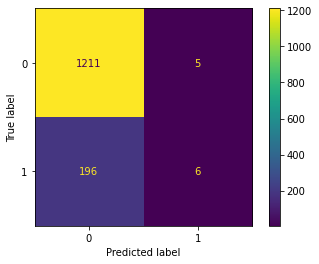

In [26]:
# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정  ########################################################################

## 데이터 분류 및 전처리
# 축 분리#te
Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions

# 사이킷런 셋 분류 함수 : http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) ## test.size 0.2~0.25 설정할거임


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
plot_confusion_matrix(pipe,X_test,Y_test)

0       0
1       1
2       1
3       1
4       1
       ..
4721    0
4722    0
4723    0
4724    0
4725    0
Name: HE_DM, Length: 4726, dtype: int64

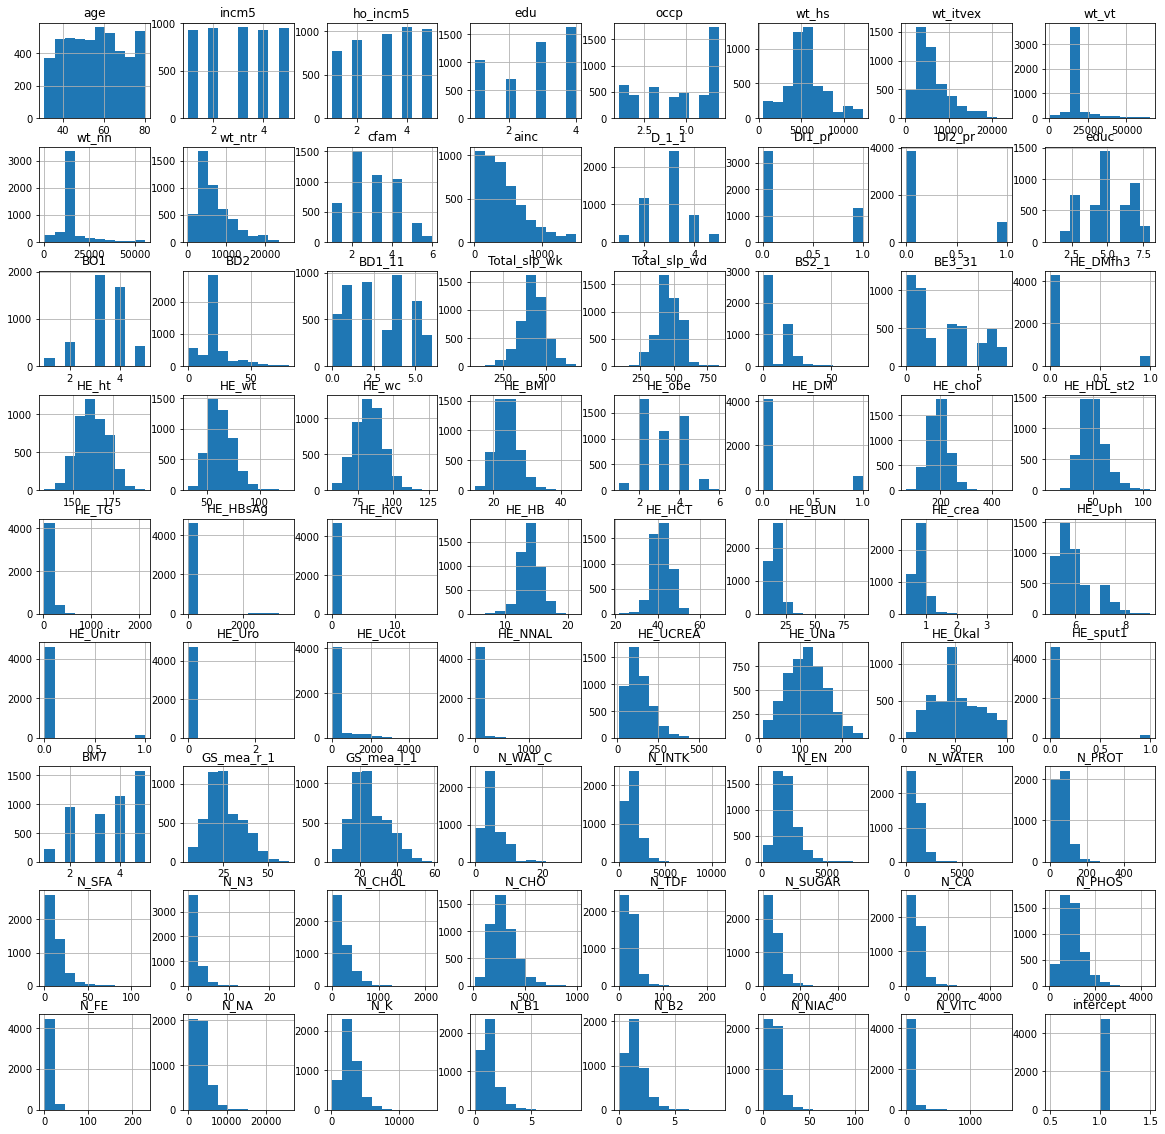

In [27]:
##########################PHASE3#############################
# STEP 4 - Data에 대한 구조와 분석
df.hist(figsize=(20,20))#histogram plotting
#sns.paiplot(df)
df.head()
df['HE_DM']

In [31]:
# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 #################################################################### 

## 변수간 상관관계 분석 - 1 
t=df.corr(method='pearson') ## de1_pr 현재 당뇨병 유병 여부와 상관관계가 있는 변수들
t.HE_DM

age             0.239156
incm5          -0.063974
ho_incm5       -0.030127
edu            -0.191204
occp            0.117487
wt_hs          -0.010544
wt_itvex       -0.077555
wt_vt          -0.022300
wt_nn          -0.035757
wt_ntr         -0.072860
cfam           -0.144739
ainc           -0.144718
D_1_1           0.149395
DI1_pr          0.260335
DI2_pr          0.230516
educ           -0.184638
BO1             0.059861
BD2             0.000586
BD1_11         -0.049406
Total_slp_wk    0.009047
Total_slp_wd   -0.043168
BS2_1           0.058243
BE3_31          0.008557
HE_DMfh3        0.200898
HE_ht          -0.039110
HE_wt           0.076099
HE_wc           0.219399
HE_BMI          0.135519
HE_obe          0.134262
HE_DM           1.000000
HE_chol        -0.201166
HE_HDL_st2     -0.160215
HE_TG           0.140561
HE_HBsAg       -0.027463
HE_hcv          0.025720
HE_HB           0.011536
HE_HCT          0.000078
HE_BUN          0.153492
HE_crea         0.115088
HE_Uph         -0.048574


In [39]:
## VIF 산출
#df.dropna(inplace=True)
df['intercept'] = 1
lm = sm.OLS(df['HE_DM'], df)
results = lm.fit()
results.summary()

# dmatrix 사용을 위한 모든 변수에 대한 string +
cols = ''
for col in list(df):
    if(col=='sex'):
        cols = cols + str(col)
    else:
        cols = cols + ' + ' + str(col)
print(cols)

 + age + incm5 + ho_incm5 + edu + occp + wt_hs + wt_itvex + wt_vt + wt_nn + wt_ntr + cfam + ainc + D_1_1 + DI1_pr + DI2_pr + educ + BO1 + BD2 + BD1_11 + Total_slp_wk + Total_slp_wd + BS2_1 + BE3_31 + HE_DMfh3 + HE_ht + HE_wc + HE_BMI + HE_obe + HE_DM + HE_chol + HE_HDL_st2 + HE_TG + HE_HBsAg + HE_hcv + HE_HCT + HE_BUN + HE_crea + HE_Uph + HE_Unitr + HE_Uro + HE_Ucot + HE_NNAL + HE_UCREA + HE_UNa + HE_Ukal + HE_sput1 + BM7 + GS_mea_r_1 + GS_mea_l_1 + N_WAT_C + N_INTK + N_WATER + N_PROT + N_SFA + N_N3 + N_CHOL + N_CHO + N_TDF + N_SUGAR + N_CA + N_PHOS + N_FE + N_NA + N_K + N_B1 + N_B2 + N_NIAC + N_VITC + intercept


In [40]:
## VIF 지수 산출 - 10 이상인 친구들     
y, X = dmatrices('HE_DM ~'+ cols , df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
# ov_list=list(vif,list(vif['VIF Factor']>10))
# print(ov_list)
vif.head(200)
over_vif_vars = vif[vif['VIF Factor']>10]
over_vif_vars.head(200)

c:\users\좌\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
27,12.414073,HE_BMI
53,11.729604,N_PROT
61,17.796957,N_PHOS


In [41]:
# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 #########################################################################

importance_list = []
y = df.HE_DM # y축 설정
x = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(x_train,y_train)
for name, score in zip(df[:],rnd_clf.feature_importances_): ## RF 적 방법으로 변수 중요도 추출
    importance_list = importance_list + [name,score]
    print(name, round(score,6))

age 0.028029
incm5 0.005188
ho_incm5 0.006187
edu 0.006907
occp 0.006675
wt_hs 0.014596
wt_itvex 0.014903
wt_vt 0.007513
wt_nn 0.010691
wt_ntr 0.0146
cfam 0.007222
ainc 0.020884
D_1_1 0.006412
DI1_pr 0.017107
DI2_pr 0.017014
educ 0.010185
BO1 0.00671
BD2 0.012611
BD1_11 0.008356
Total_slp_wk 0.01216
Total_slp_wd 0.013164
BS2_1 0.008824
BE3_31 0.008703
HE_DMfh3 0.020242
HE_ht 0.016897
HE_wc 0.037654
HE_BMI 0.020498
HE_obe 0.006166
HE_DM 0.049476
HE_chol 0.023299
HE_HDL_st2 0.029201
HE_TG 0.016447
HE_HBsAg 0.01302
HE_hcv 0.021335
HE_HCT 0.022487
HE_BUN 0.022429
HE_crea 0.007969
HE_Uph 0.00192
HE_Unitr 0.000621
HE_Uro 0.017681
HE_Ucot 0.011877
HE_NNAL 0.01766
HE_UCREA 0.016762
HE_UNa 0.014965
HE_Ukal 0.000858
HE_sput1 0.007018
BM7 0.016556
GS_mea_r_1 0.016175
GS_mea_l_1 0.013371
N_WAT_C 0.01549
N_INTK 0.016151
N_WATER 0.013113
N_PROT 0.018836
N_SFA 0.01648
N_N3 0.020918
N_CHOL 0.016915
N_CHO 0.018658
N_TDF 0.01832
N_SUGAR 0.015702
N_CA 0.013895
N_PHOS 0.014042
N_FE 0.017772
N_NA 0.014749


In [42]:
#############STEP 7 - RF 중요도 날림#########3
df=df.drop(['incm5','ho_incm5','edu','occp','wt_vt','cfam','D_1_1','BO1','BD1_11','BS2_1','BE3_31','HE_obe','HE_crea','HE_Uph','HE_Unitr','HE_Ukal','HE_sput1','N_VITC'],axis='columns')
df.head()
############# STEP 7 - 18개 날라감  66 - 18 = 48 #####################

,age,wt_hs,wt_itvex,wt_nn,wt_ntr,ainc,DI1_pr,DI2_pr,educ,BD2,Total_slp_wk,Total_slp_wd,HE_DMfh3,HE_ht,HE_wc,HE_BMI,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_hcv,HE_HCT,HE_BUN,HE_Uro,HE_Ucot,HE_NNAL,HE_UCREA,HE_UNa,BM7,GS_mea_r_1,GS_mea_l_1,N_WAT_C,N_INTK,N_WATER,N_PROT,N_SFA,N_N3,N_CHOL,N_CHO,N_TDF,N_SUGAR,N_CA,N_PHOS,N_FE,N_NA,N_K,N_B1,N_B2,N_NIAC,intercept
0,80,7129.611906,11065.346820,14516.42326,12602.663140,80.000000,1,1,5,19,480,480,0,162.4,82.2,21.233226,0,111,43,83,0.55,0.08,38.7,27,0,2.5700,1.4,68.9,87,5,19.2,16.8,5.0,584.617278,413.229839,36.421414,6.574070,0.573964,104.511252,97.066580,8.024705,14.110607,137.524220,467.694365,4.771832,1327.693537,944.539521,0.664332,0.509876,4.700086,1
1,78,7129.611906,3688.448941,14516.42326,4200.887713,1500.000000,0,0,7,15,300,420,0,167.7,98.3,27.166096,1,224,36,157,0.51,0.10,42.6,22,0,0.3960,1.4,100.1,182,5,40.5,35.9,5.0,1573.428467,1008.012946,93.260455,7.572577,0.333173,206.181421,298.257700,39.887760,93.915511,430.240874,941.809087,11.041512,4961.541083,3658.637056,1.175553,1.217959,16.821098,1
2,75,7129.611906,5244.077972,14516.42326,5622.287006,1500.000000,1,0,5,0,360,480,1,157.7,80.7,21.391845,1,165,44,101,0.59,12.06,42.3,15,0,0.7875,1.4,105.1,153,5,15.3,10.3,5.0,1194.733365,758.479721,42.516444,23.130683,2.193219,495.097017,320.072436,44.459450,120.949600,342.242264,842.370409,7.348493,2087.228977,3072.114196,0.638100,1.337223,4.785608,1
3,80,7129.611906,5244.077972,14516.42326,5622.287006,75.666667,0,0,3,0,450,450,0,146.1,93.0,26.984977,1,160,32,229,0.52,0.06,30.2,23,0,0.4480,1.4,67.3,140,2,8.6,14.6,2.5,526.064249,271.549260,24.806971,2.329953,0.356655,3.729000,211.241049,16.174439,22.942586,146.555175,609.814863,5.071129,2886.722704,1244.294594,0.877007,0.305087,6.082442,1
4,71,7129.611906,3315.581424,14516.42326,3268.787290,75.666667,1,0,7,21,300,360,1,157.2,78.4,21.528142,1,167,62,54,0.64,0.04,37.5,25,0,0.8110,1.4,62.7,159,2,15.3,14.3,10.0,1271.085794,540.182372,35.319840,16.748430,0.312280,65.398719,221.474668,20.316407,78.265128,587.222358,793.749899,4.773000,605.814716,2280.084010,0.646209,1.248963,6.526215,1


0.8610719322990127


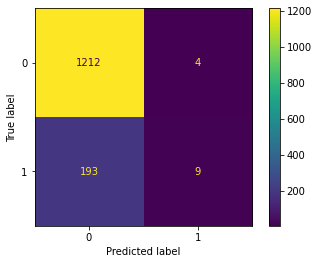

In [43]:
# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정  ########################################################################

## 데이터 분류 및 전처리
# 축 분리#te
Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions

# 사이킷런 셋 분류 함수 : http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) ## test.size 0.2~0.25 설정할거임


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
plot_confusion_matrix(pipe,X_test,Y_test)

0       0
1       1
2       1
3       1
4       1
       ..
4721    0
4722    0
4723    0
4724    0
4725    0
Name: HE_DM, Length: 4726, dtype: int64

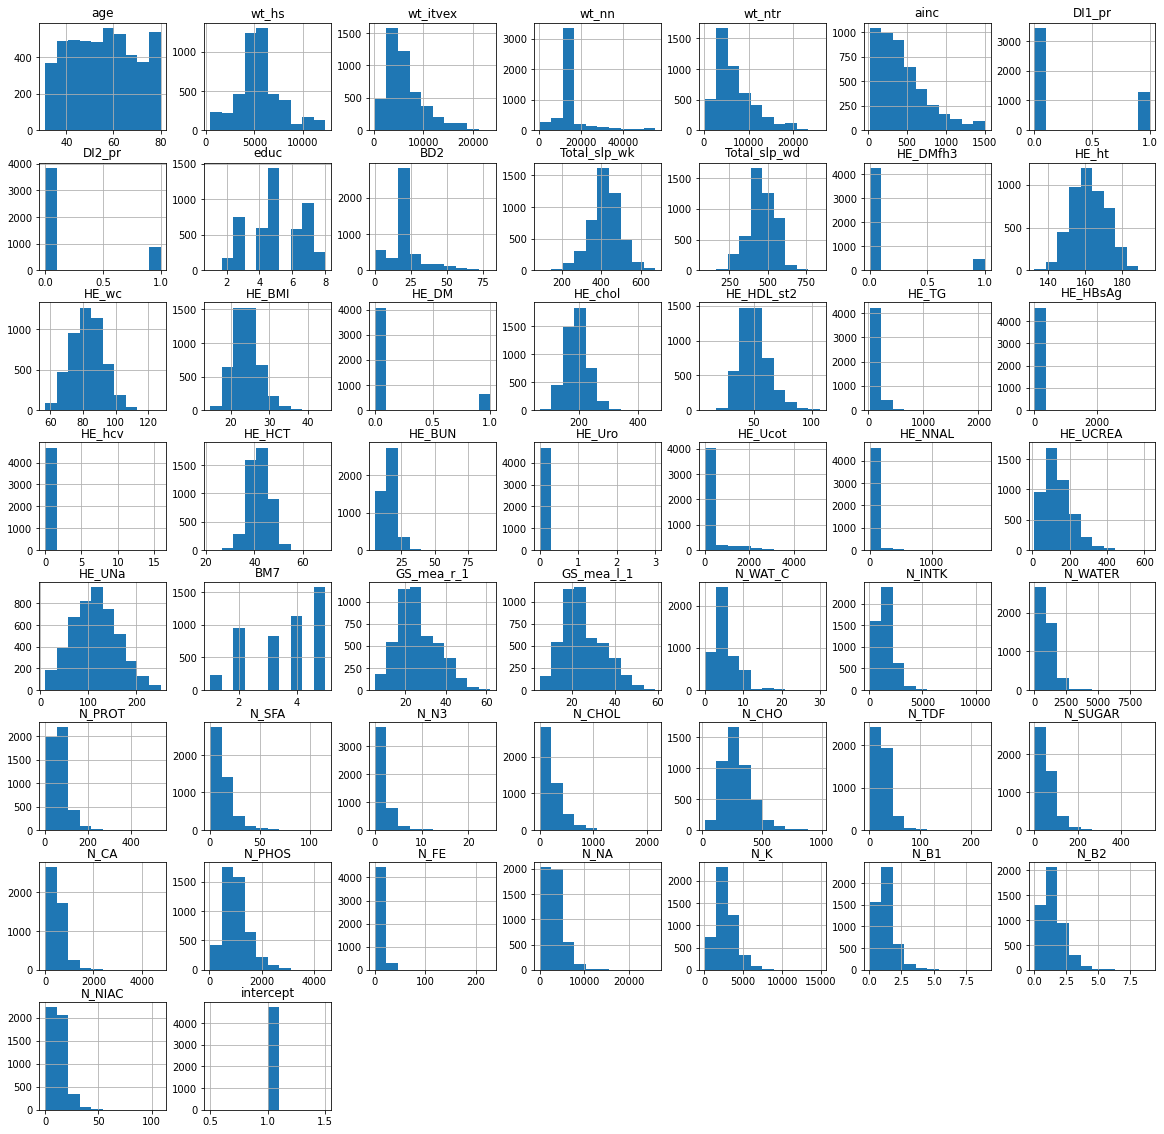

In [46]:
##########################PHASE4#############################
# STEP 4 - Data에 대한 구조와 분석
df.hist(figsize=(20,20))#histogram plotting
#sns.paiplot(df)
df.head()
df['HE_DM']

In [47]:
# STEP 5 = 변수간 상관관계 및 다중공선성(VIF) 분석 #################################################################### 

## 변수간 상관관계 분석 - 1 
t=df.corr(method='pearson') ## de1_pr 현재 당뇨병 유병 여부와 상관관계가 있는 변수들
t.HE_DM

age             0.239156
wt_hs          -0.010544
wt_itvex       -0.077555
wt_nn          -0.035757
wt_ntr         -0.072860
ainc           -0.144718
DI1_pr          0.260335
DI2_pr          0.230516
educ           -0.184638
BD2             0.000586
Total_slp_wk    0.009047
Total_slp_wd   -0.043168
HE_DMfh3        0.200898
HE_ht          -0.039110
HE_wc           0.219399
HE_BMI          0.135519
HE_DM           1.000000
HE_chol        -0.201166
HE_HDL_st2     -0.160215
HE_TG           0.140561
HE_HBsAg       -0.027463
HE_hcv          0.025720
HE_HCT          0.000078
HE_BUN          0.153492
HE_Uro         -0.004110
HE_Ucot        -0.011004
HE_NNAL         0.010641
HE_UCREA       -0.074801
HE_UNa         -0.018659
BM7            -0.115501
GS_mea_r_1     -0.037542
GS_mea_l_1     -0.031009
N_WAT_C         0.005168
N_INTK         -0.062615
N_WATER        -0.063514
N_PROT         -0.055117
N_SFA          -0.095722
N_N3           -0.022745
N_CHOL         -0.089632
N_CHO           0.010982


In [49]:
## VIF 산출
#df.dropna(inplace=True)
df['intercept'] = 1
lm = sm.OLS(df['HE_DM'], df)
results = lm.fit()
results.summary()

# dmatrix 사용을 위한 모든 변수에 대한 string +
cols = ''
for col in list(df):
    if(col=='sex'):
        cols = cols + str(col)
    else:
        cols = cols + ' + ' + str(col)
print(cols)

 + age + wt_hs + wt_itvex + wt_nn + wt_ntr + ainc + DI1_pr + DI2_pr + educ + BD2 + Total_slp_wk + Total_slp_wd + HE_DMfh3 + HE_ht + HE_wc + HE_BMI + HE_DM + HE_chol + HE_HDL_st2 + HE_TG + HE_HBsAg + HE_hcv + HE_HCT + HE_BUN + HE_Uro + HE_Ucot + HE_NNAL + HE_UCREA + HE_UNa + BM7 + GS_mea_r_1 + GS_mea_l_1 + N_WAT_C + N_INTK + N_WATER + N_PROT + N_SFA + N_N3 + N_CHOL + N_CHO + N_TDF + N_SUGAR + N_CA + N_PHOS + N_FE + N_NA + N_K + N_B1 + N_B2 + N_NIAC + intercept


In [50]:
## VIF 지수 산출 - 10 이상인 친구들     
y, X = dmatrices('HE_DM ~'+ cols , df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
# ov_list=list(vif,list(vif['VIF Factor']>10))
# print(ov_list)
vif.head(200)
over_vif_vars = vif[vif['VIF Factor']>10]
over_vif_vars.head(200)

c:\users\좌\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
36,11.635414,N_PROT
44,17.701736,N_PHOS


In [51]:
# STEP 6 - 변수의 RF 모델에서 나온 중요도 산출 #########################################################################

importance_list = []
y = df.HE_DM # y축 설정
x = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(x_train,y_train)
for name, score in zip(df[:],rnd_clf.feature_importances_): ## RF 적 방법으로 변수 중요도 추출
    importance_list = importance_list + [name,score]
    print(name, round(score,6))

age 0.031483
wt_hs 0.017739
wt_itvex 0.018437
wt_nn 0.012068
wt_ntr 0.017872
ainc 0.024849
DI1_pr 0.021993
DI2_pr 0.01842
educ 0.012941
BD2 0.015516
Total_slp_wk 0.014434
Total_slp_wd 0.015346
HE_DMfh3 0.023862
HE_ht 0.018578
HE_wc 0.044261
HE_BMI 0.025753
HE_DM 0.052894
HE_chol 0.026694
HE_HDL_st2 0.033638
HE_TG 0.019238
HE_HBsAg 0.014686
HE_hcv 0.023574
HE_HCT 0.02635
HE_BUN 0.000748
HE_Uro 0.020499
HE_Ucot 0.014289
HE_NNAL 0.02183
HE_UCREA 0.02053
HE_UNa 0.007595
BM7 0.019389
GS_mea_r_1 0.019899
GS_mea_l_1 0.016807
N_WAT_C 0.01811
N_INTK 0.020086
N_WATER 0.016461
N_PROT 0.020625
N_SFA 0.019592
N_N3 0.024221
N_CHOL 0.021068
N_CHO 0.021896
N_TDF 0.022095
N_SUGAR 0.018708
N_CA 0.016946
N_PHOS 0.016444
N_FE 0.020625
N_NA 0.017418
N_K 0.017479
N_B1 0.01881
N_B2 0.017202
N_NIAC 0.0


In [54]:
#############STEP 7 - RF 중요도 날림#########3
df=df.drop(['wt_hs','wt_nn','wt_ntr','educ','BD2','Total_slp_wk','Total_slp_wd','HE_HBsAg','HE_BUN','HE_Ucot','HE_UNa','GS_mea_l_1','N_WATER','N_CA','N_PHOS','N_NA','N_K','N_B2','N_NIAC'],axis='columns')
df.head()
############# STEP 7 - 18개 날라감  48 - 19 = 29 #####################

KeyError: "['wt_hs' 'wt_nn' 'wt_ntr' 'educ' 'BD2' 'Total_slp_wk' 'Total_slp_wd'\n 'HE_HBsAg' 'HE_BUN' 'HE_Ucot' 'HE_UNa' 'GS_mea_l_1' 'N_WATER' 'N_CA'\n 'N_PHOS' 'N_NA' 'N_K' 'N_B2' 'N_NIAC'] not found in axis"

0.8610719322990127


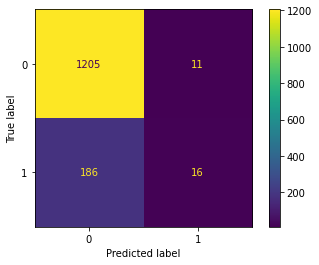

In [55]:
# STEP 8 - 파이프라이닝 - 스케일링 / 모델링 결정  ########################################################################

## 데이터 분류 및 전처리
# 축 분리#te
Y = df.HE_DM # y축 설정
X = df.drop(columns=["HE_DM"]) #결과축 삭제 for predictions

# 사이킷런 셋 분류 함수 : http://blog.naver.com/PostView.nhn?blogId=siniphia&logNo=221396370872
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42) ## test.size 0.2~0.25 설정할거임


pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train,Y_train)
y_preds=pipe.predict(X_test)
print(pipe.score(X_test,Y_test))
plot_confusion_matrix(pipe,X_test,Y_test)